In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

from src.sdes import sde_utils, time, sde_kunita
from src import data_boundary_pts

from experiments.plotting import load_checkpoint_w_batch_stats, load_checkpoint_wo_batch_stats, checkpoint_unet

Setup to load in checkpoint

In [2]:
T = 1.0
N = 100

In [3]:
num_landmarks = 5

checkpoint_path = f"../../checkpoints/kunita/circ_r1_lms_5"
# checkpoint_path = f"../../checkpoints/kunita/fixed_x0_lms_5"
trained_score, _ = checkpoint_unet(checkpoint_path)

In [4]:
keys = jax.random.split(jax.random.PRNGKey(0), 10)
ts = time.grid(0, T, N)

# def sample_circle(num_landmarks: int, radius=1.0, centre=jnp.asarray([0, 0])) -> jnp.ndarray:
#     theta = jnp.linspace(0, 2 * jnp.pi, num_landmarks, endpoint=False)
#     x = jnp.cos(theta)
#     y = jnp.sin(theta)
#     return (radius * jnp.stack([x, y], axis=1) + centre).flatten()

# x0 = sample_circle(num_landmarks, 1.2)

y = data_boundary_pts.sample_circle(num_landmarks)
target = y.reshape(-1, 2)

x0 = data_boundary_pts.sample_circle(num_landmarks, 1.2)

drift, diffusion = sde_kunita.vector_fields()
bm_shape = (sde_kunita.GRID_SIZE**2 * 2,)

conditioned_trajs = jax.vmap(sde_utils.conditioned, (0, None, None, None, None, None, None))(keys, ts, x0, trained_score, drift, diffusion, bm_shape)

forward_trajs = jax.vmap(sde_utils.solution, (0, None, None, None, None, None))(keys, ts, x0, drift, diffusion, bm_shape)


# conditioned_traj = sde_utils.conditioned(key, ts, x0, trained_score, drift, diffusion, bm_shape)
# forward_traj = sde_utils.solution(key, ts, x0, drift, diffusion, bm_shape)

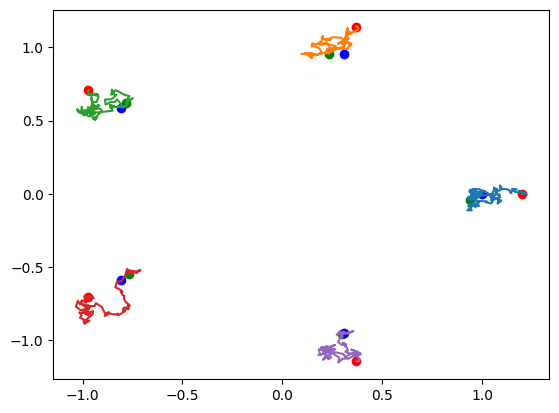

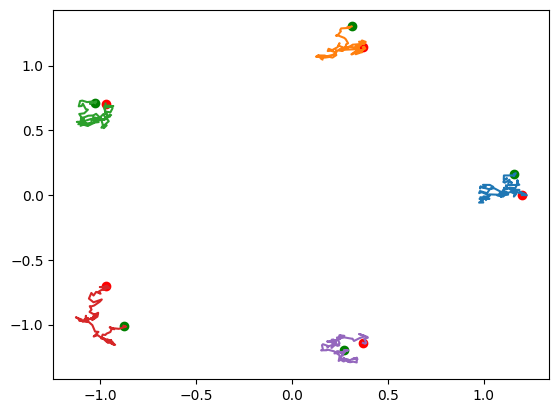

In [5]:
traj = 5
conditioned_traj = conditioned_trajs[traj].reshape(-1, num_landmarks, 2)

for landmark in range(conditioned_traj.shape[1]):
    plt.plot(conditioned_traj[:, landmark, 0], conditioned_traj[:, landmark, 1])
    plt.scatter(conditioned_traj[0, landmark, 0], conditioned_traj[0, landmark, 1], c='red')
    plt.scatter(conditioned_traj[-1, landmark, 0], conditioned_traj[-1, landmark, 1], c='green')
    plt.scatter(target[landmark, 0], target[landmark, 1], c='blue')
plt.show()

forward_traj = forward_trajs[traj].reshape(-1, num_landmarks, 2)

for landmark in range(forward_traj.shape[1]):
    plt.plot(forward_traj[:, landmark, 0], forward_traj[:, landmark, 1])
    plt.scatter(forward_traj[0, landmark, 0], forward_traj[0, landmark, 1], c='red')
    plt.scatter(forward_traj[-1, landmark, 0], forward_traj[-1, landmark, 1], c='green')
plt.show()